# Thông tin sinh viên

- Họ và tên: Đinh Xuân Khương
- MSSV: 23127398
- Lớp: 23CLC04

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Import thêm dữ thư viện nếu cần

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu  bằng pandas
train = pd.read_csv('p03.train.csv')
test = pd.read_csv('p03.test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [3]:

# Cài đặt các hàm cần thiết ở đây
class OLSLinearRegression:
    def fit(self, X, y):
        ''' 
        This function is used to fit the model to the data. It uses the Ordinary Least Squares method to find the optimal parameters.

        Parameters
        ----------
        X : np.ndarray
            Input data
        y : np.ndarray
            Output data

        Returns
        -------
        self : object
            Returns the instance of the class
        
        '''

        X_pinv =  np.linalg.pinv(X) #np.linalg.inv(X.T @ X) @ X.T 
        self.w = X_pinv @ y

        return self


    def get_params(self):
        ''' 
        This function is used to get the parameters of the model.

        Returns
        -------
        self.w : np.ndarray
            Optimal parameters (column vector)
        '''

        return self.w


    def predict(self, X):
        ''' 
        This function is used to predict the output of the model.

        Parameters
        ----------
        X : np.ndarray
            Input data

        Returns
        -------
        X @ self.w : np.ndarray
            Predicted output
        '''

        return X @ self.w  

def df_to_numpy(dataframe):
    '''
    Convert a pandas DataFrame to a numpy array.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Input DataFrame

    Returns
    -------
    np.ndarray
        Output numpy array: np.ndarray
    '''
    return dataframe.to_numpy()

def cal_mse(y, y_predicted):
    '''
    Calculate the Mean Squared Error (MSE) between the true and predicted values.

    Parameters
    ----------
    y : np.ndarray
        True output values
    y_predicted : np.ndarray
        Predicted output values

    Returns
    -------
    float
        Mean Squared Error
    '''
    return np.mean((y - y_predicted)**2)

def plot_compare(y_test, y_predicted):
    """
    Plot a side-by-side comparison of true and predicted target values.

    This function visualizes how closely the predicted values match the
    actual values by plotting both on the same graph. To make the plot
    less cluttered, only every 20th data point is shown.

    Parameters
    ----------
    y_test : np.ndarray
        Array of true target values, shape (n_samples,).
    y_predicted : np.ndarray
        Array of predicted target values, shape (n_samples,).

    Returns
    -------
    None
        The function generates and displays a matplotlib plot.

    Notes
    -----
    - The function uses a fixed sampling step of 20 to improve readability. 
      If your dataset is small, you may want to reduce or remove this step.
    - Both arrays must have the same length; otherwise, the function will
      raise an IndexError during plotting.

    """
    
    step = 20
    plt.plot(y_test[::step], label='y_test', alpha=0.7)
    plt.plot(y_predicted[::step], label='y_predicted', alpha=0.7)

    plt.legend()
    plt.xlabel('Index sample')
    plt.ylabel('Value')
    plt.title('y_test vs y_predicted')
    plt.show()
    

def k_fold_cross_validation(X, y, model, input_indices, k=5):
    """
    Perform k-fold cross-validation to evaluate a model's performance.

    This function splits the dataset into `k` roughly equal-sized folds, 
    using the provided `input_indices` to determine the sample order. 
    For each fold, the model is trained on `k-1` folds and evaluated 
    on the remaining fold. The evaluation metric is the Mean Squared Error (MSE), 
    and the function returns the average MSE across all folds.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix .
    y : np.ndarray
        Target values.
    model : object
        The model instance to be trained and evaluated.
        Must implement `fit(X, y)` and `predict(X)` methods.
    input_indices : np.ndarray
        Array of indices specifying the order in which samples should be split 
        into folds. Typically obtained from `np.arange(len(X))` or a shuffled version.
    k : int, optional, default=5
        Number of folds to use for cross-validation.
        Must be at least 2 and at most the number of samples.

    Returns
    -------
    float
        The average Mean Squared Error (MSE) computed over all folds.

    Notes
    -----
    - This implementation uses a deterministic split based on `input_indices`.
      Randomness in the fold division must be introduced before calling 
      this function (e.g., by shuffling `input_indices`).
    - The function uses `cal_mse(y_true, y_pred)` to compute MSE. 
    - The input `X` and `y` must be indexable using NumPy-style indexing.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.linear_model import LinearRegression
    >>> X = np.random.rand(10, 3)
    >>> y = np.random.rand(10)
    >>> model = LinearRegression()
    >>> indices = np.arange(len(X))
    >>> np.random.shuffle(indices)
    >>> avg_mse = k_fold_cross_validation(X, y, model, indices, k=5)
    >>> print(avg_mse)
    0.1234
    """
    n_samples = len(X)
    
    fold_sizes = np.full(k, n_samples // k, dtype=int)
    fold_sizes[:n_samples % k] += 1  # chia đều số mẫu dư

    current = 0
    scores = []

    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = input_indices[start:stop]
        train_idx = np.concatenate((input_indices[:start], input_indices[stop:]))

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # Huấn luyện
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = cal_mse(y_val, y_pred)
        scores.append(mse)

        current = stop

    return np.mean(scores)

def add_bias(X):
    """
    Add a bias (intercept) column to the input feature matrix.

    This function prepends a column of ones to the given feature matrix `X`, 
    which is commonly required in linear regression and other models 
    that explicitly include an intercept term in the parameter vector.

    Parameters
    ----------
    X : np.ndarray
        Input feature matrix of shape (m_samples, n_features).

    Returns
    -------
    np.ndarray
        Modified feature matrix of shape (m_samples, n_features + 1),
        where the first column consists of ones representing the bias term,
        and the remaining columns are the original features.
    Notes
    -----
    - This function assumes that `X` is a 2D NumPy array. 
      If you pass a 1D array, reshape it to `(m_samples, n_features)` first.
    - Adding the bias term manually is typically needed when implementing
      linear regression from scratch, as libraries like scikit-learn often
      handle the intercept internally.

    Examples
    --------
    >>> import numpy as np
    >>> X = np.array([[2, 3],
    ...               [4, 5],
    ...               [6, 7]])
    >>> add_bias(X)
    array([[1., 2., 3.],
           [1., 4., 5.],
           [1., 6., 7.]])
    """

    # Thêm cột 1 vào X
    return np.hstack((np.ones((X.shape[0], 1)), X))


*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu

In [4]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)

X_train shape:  (9000, 5)
Y_train shape:  (9000,)


In [5]:
X_train.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
0,7,77,0,5,2
1,8,90,1,4,1
2,9,83,1,6,3
3,4,52,0,9,5
4,4,82,1,8,6


In [6]:
X_train.tail()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
8995,2,41,1,4,6
8996,3,74,1,4,1
8997,7,65,0,4,1
8998,8,48,0,7,7
8999,4,59,0,9,7


In [7]:
train.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,77,0,5,2,69.0
1,8,90,1,4,1,84.0
2,9,83,1,6,3,82.0
3,4,52,0,9,5,38.0
4,4,82,1,8,6,68.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9000 non-null   int64  
 1   Previous Scores                   9000 non-null   int64  
 2   Extracurricular Activities        9000 non-null   int64  
 3   Sleep Hours                       9000 non-null   int64  
 4   Sample Question Papers Practiced  9000 non-null   int64  
 5   Performance Index                 9000 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 422.0 KB


In [9]:
train.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4.976444,69.396111,0.493667,6.535556,4.590889,55.136333
std,2.594647,17.369957,0.499988,1.695533,2.864570,19.187669
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,70.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


#### Histograms

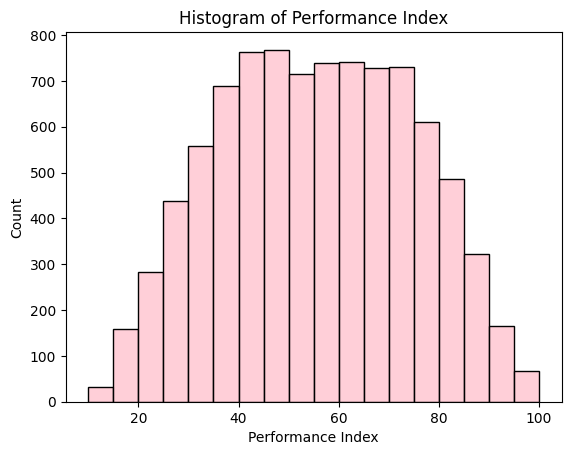

In [10]:
ax = sns.histplot(y_train, binrange=(10,100), binwidth = 5, color= 'pink')
plt.title("Histogram of Performance Index")
plt.show()

Phân phối chuẩn, cho thấy mẫu này khá tốt để đánh giá và khám phá. Cũng như đưa ra các giả thuyết để kiểm định

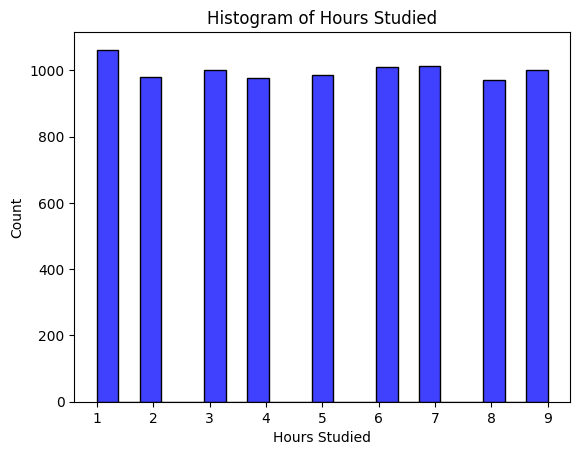

In [11]:
ax = sns.histplot(X_train["Hours Studied"], color= 'blue')
plt.title("Histogram of Hours Studied")
plt.show()

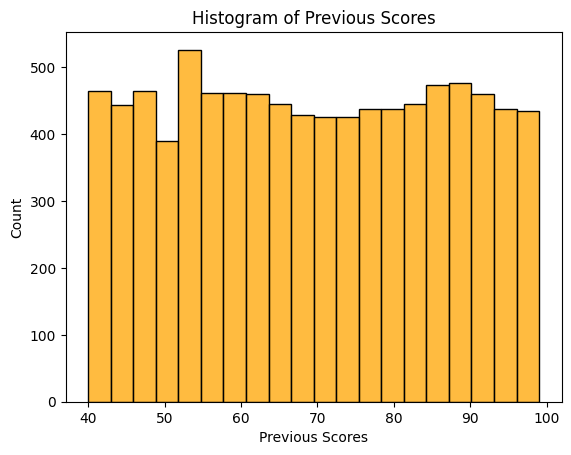

In [12]:
ax = sns.histplot(X_train["Previous Scores"], color= 'orange')
plt.title("Histogram of Previous Scores")
plt.show()

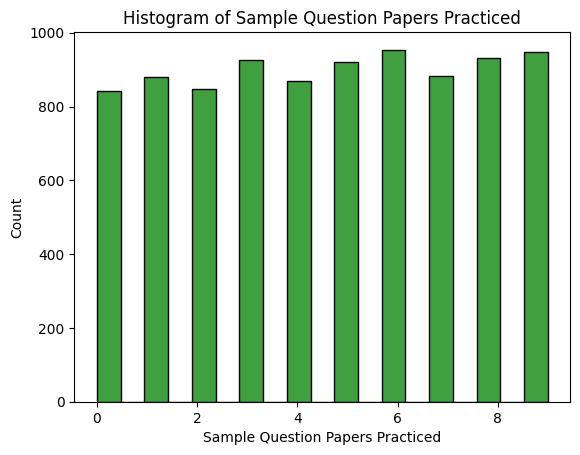

In [13]:
ax = sns.histplot(X_train["Sample Question Papers Practiced"], color= 'green')
plt.title("Histogram of Sample Question Papers Practiced")
plt.show()

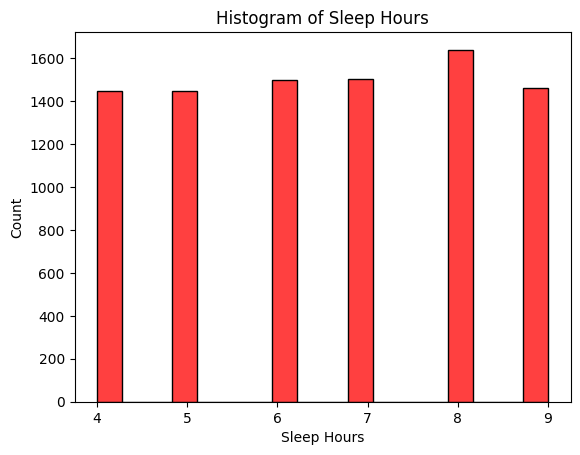

In [14]:
ax = sns.histplot(X_train["Sleep Hours"], color= 'r')
plt.title("Histogram of Sleep Hours")
plt.show()

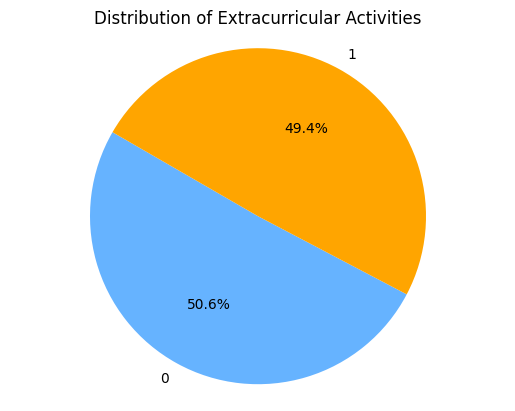

In [15]:
# Count the values
activity_counts = X_train['Extracurricular Activities'].value_counts()

# Create the pie chart
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', colors=['#66b3ff','orange'], startangle=150)
plt.title("Distribution of Extracurricular Activities")
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle.
plt.show()

Các phân phối của các đặc trưng trên khá đồng đều nhau, cho thấy sự ổn định và không bias trong dataset này.

### The dependency of Performance Index on other features 

#### Hours Studied

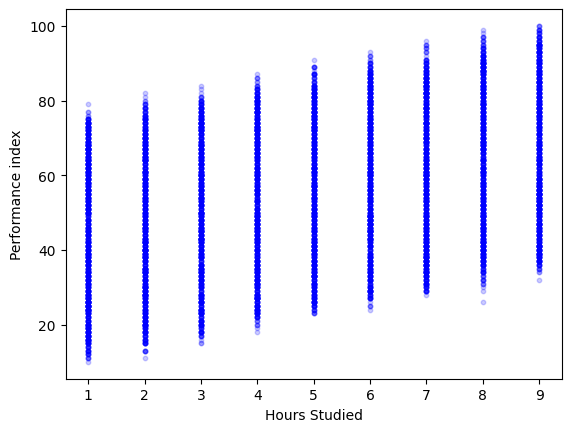

In [16]:
plt.scatter(X_train["Hours Studied"], y_train, color='blue', marker='o', s=10, alpha=0.2)

# Labels and title
plt.xlabel('Hours Studied')
plt.ylabel('Performance index')
plt.show()


Có thể có mối quan hệ tuyến tính nhẹ ở đây với Hours Studied

#### Previous Scores

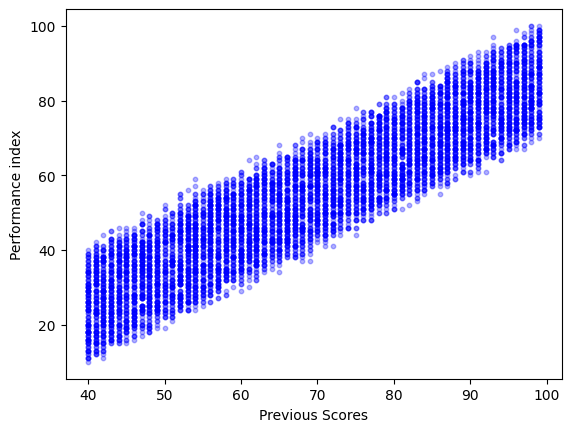

In [17]:
plt.scatter(X_train["Previous Scores"], y_train, color = "b", s = 10, alpha= 0.3)

plt.xlabel('Previous Scores')
plt.ylabel('Performance index')
plt.show()

Có khả năng có mối quan hệ tuyến tính mạnh ở đây

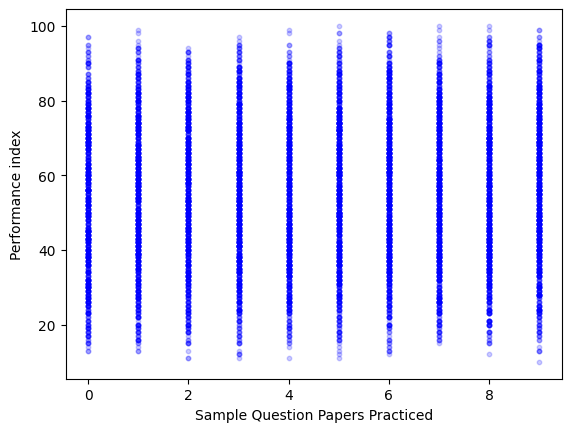

In [18]:
plt.scatter(X_train["Sample Question Papers Practiced"], y_train, color = "b", s = 10, alpha= 0.2)

plt.xlabel('Sample Question Papers Practiced')
plt.ylabel('Performance index')
plt.show()

Không đánh giá được nhiều với biểu đồ này


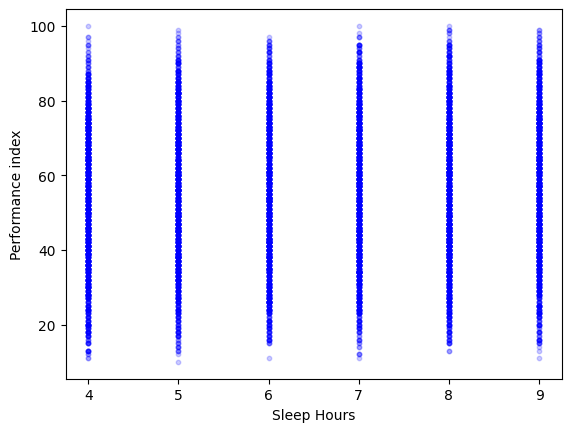

In [19]:
plt.scatter(X_train["Sleep Hours"], y_train, color='blue', marker='o', s=10, alpha=0.2)

# Labels and title
plt.xlabel('Sleep Hours')
plt.ylabel('Performance index')
plt.show()

Không đánh giá được nhiều ở biểu đồ này

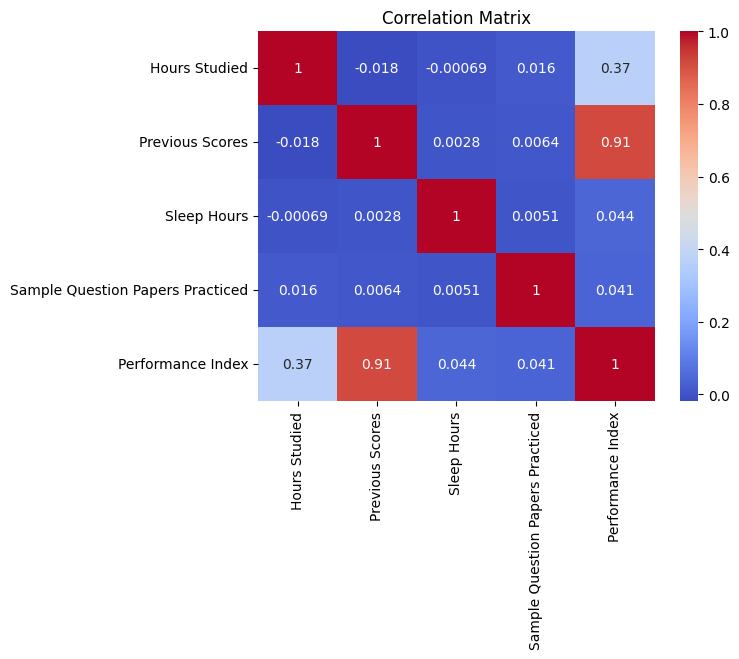

In [20]:
correlation_matrix = train[['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

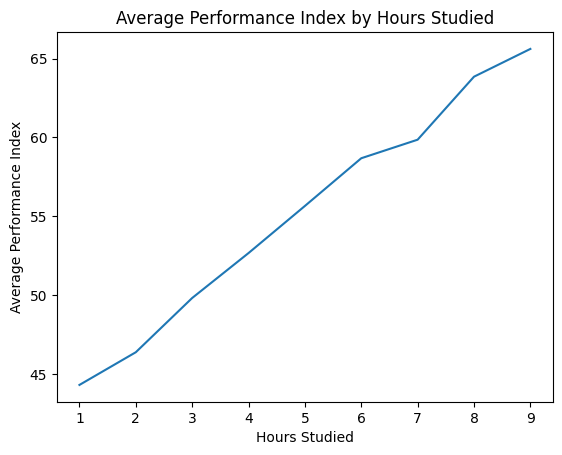

In [21]:
avg_performance_by_hours = train.groupby('Hours Studied')['Performance Index'].mean()
plt.plot(avg_performance_by_hours.index, avg_performance_by_hours.values)
plt.xlabel('Hours Studied')
plt.ylabel('Average Performance Index')
plt.title('Average Performance Index by Hours Studied')
plt.show()

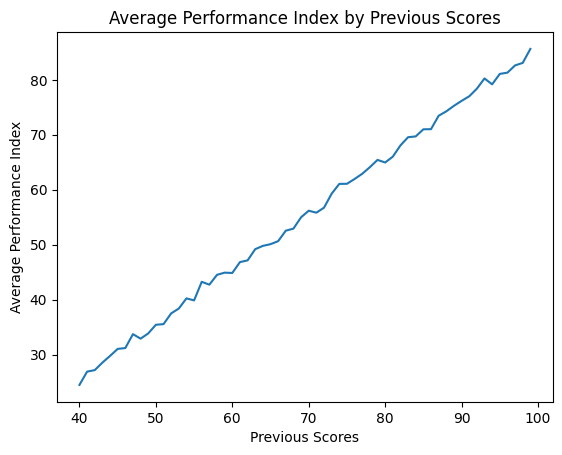

In [22]:
avg_performance_by_previous_score = train.groupby('Previous Scores')['Performance Index'].mean()
plt.plot(avg_performance_by_previous_score.index, avg_performance_by_previous_score.values)
plt.xlabel('Previous Scores')
plt.ylabel('Average Performance Index')
plt.title('Average Performance Index by Previous Scores')
plt.show()

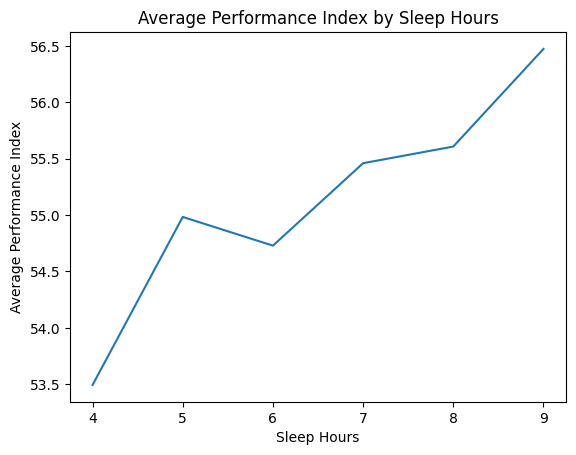

In [23]:
avg_performance_by_sleep_hours = train.groupby('Sleep Hours')['Performance Index'].mean()
plt.plot(avg_performance_by_sleep_hours.index, avg_performance_by_sleep_hours.values)
plt.xlabel('Sleep Hours')
plt.ylabel('Average Performance Index')
plt.title('Average Performance Index by Sleep Hours')
plt.show()

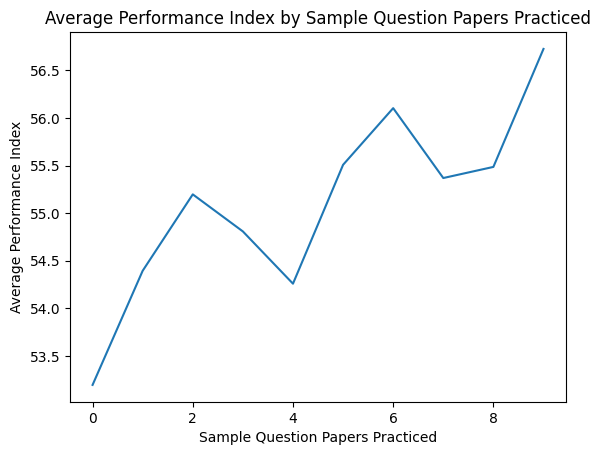

In [24]:
avg_performance_by_sample_papers = train.groupby('Sample Question Papers Practiced')['Performance Index'].mean()
plt.plot(avg_performance_by_sample_papers.index, avg_performance_by_sample_papers.values)
plt.xlabel('Sample Question Papers Practiced')
plt.ylabel('Average Performance Index')
plt.title('Average Performance Index by Sample Question Papers Practiced')
plt.show()

# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp

In [25]:
# Phần code cho yêu cầu 2a
X_train_ndarray = df_to_numpy(X_train)
y_train_ndarray = df_to_numpy(y_train)

x_test_ndarray = df_to_numpy(X_test)
y_test_ndarray = df_to_numpy(y_test)

In [26]:
X_train_ndarray

array([[ 7, 77,  0,  5,  2],
       [ 8, 90,  1,  4,  1],
       [ 9, 83,  1,  6,  3],
       ...,
       [ 7, 65,  0,  4,  1],
       [ 8, 48,  0,  7,  7],
       [ 4, 59,  0,  9,  7]], shape=(9000, 5))

In [27]:
X_train_with_bias = add_bias(X_train_ndarray)
X_train_with_bias

array([[ 1.,  7., 77.,  0.,  5.,  2.],
       [ 1.,  8., 90.,  1.,  4.,  1.],
       [ 1.,  9., 83.,  1.,  6.,  3.],
       ...,
       [ 1.,  7., 65.,  0.,  4.,  1.],
       [ 1.,  8., 48.,  0.,  7.,  7.],
       [ 1.,  4., 59.,  0.,  9.,  7.]], shape=(9000, 6))

In [28]:
X_test_with_bias = add_bias(x_test_ndarray)
X_test_with_bias

array([[ 1.,  7., 74.,  0.,  8.,  1.],
       [ 1.,  6., 89.,  1.,  8.,  8.],
       [ 1.,  3., 79.,  0.,  8.,  1.],
       ...,
       [ 1.,  9., 44.,  0.,  9.,  9.],
       [ 1.,  3., 41.,  1.,  5.,  6.],
       [ 1.,  8., 93.,  0.,  6.,  0.]], shape=(1000, 6))

In [29]:

model_with_5_features = OLSLinearRegression().fit(X_train_with_bias, y_train_ndarray)

w_with_5_features = model_with_5_features.get_params()
print("weights using 5 features: ",w_with_5_features)

y_predicted_with_5_features = model_with_5_features.predict(X_test_with_bias)
# print("y predicted: ", y_predicted_with_5_features)



weights using 5 features:  [-33.96928368   2.85202007   1.01786957   0.60428174   0.47356583
   0.19237624]


In [30]:
# Gọi hàm MSE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
mse_5_features = cal_mse(y_test_ndarray, y_predicted_with_5_features)
print("MSE of model using 5 features: ",mse_5_features)

MSE of model using 5 features:  4.092549211630639


Để biểu diễn công thức ngắn gọn, em xin viết tắt:
- Hour Studied: HS
- Previous Scores: PS
- Extracurricular Activities: EA
- Sleep Hours: SH
- Sample Question Papers Practiced: SQPP


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.969 + 2.852 \cdot \text{HS} + 1.018 \cdot \text{PS} + 0.604 \cdot \text{EA} + 0.474 \cdot \text{SH} + 0.192 \cdot \text{SQPP}$$

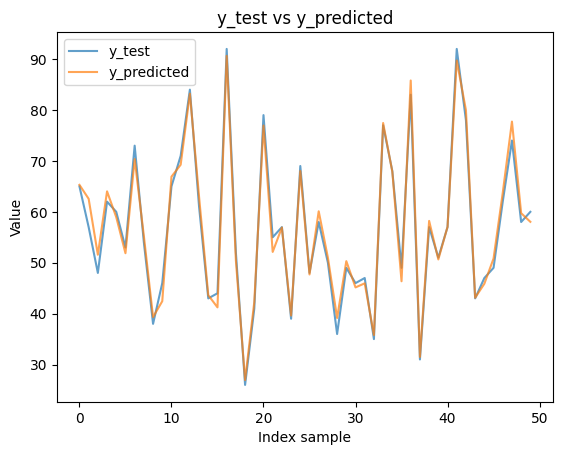

In [31]:
plot_compare(y_test_ndarray, y_predicted_with_5_features)

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [32]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu
n_samples = len(X_train_with_bias)
input_indices = np.arange(n_samples)
np.random.shuffle(input_indices)  #shuffle duy nhất 1 lần
input_indices



array([4250, 2631, 4314, ..., 3265, 1928, 1050], shape=(9000,))

In [33]:
model_hours_studied = OLSLinearRegression()
x_train_hours_studied = add_bias(df_to_numpy(train["Hours Studied"]).reshape(-1,1))

mse_model_hours_studied = k_fold_cross_validation(x_train_hours_studied, y_train_ndarray, model_hours_studied,input_indices)
print("Weights:", model_hours_studied.get_params())
print("MSE of model with feature Hours Studied: ", mse_model_hours_studied)

Weights: [41.42041584  2.76994642]
MSE of model with feature Hours Studied:  318.24493021268927


In [34]:
model_previous_scores = OLSLinearRegression()
x_train_previous_scores = add_bias(df_to_numpy(train["Previous Scores"]).reshape(-1,1))

mse_model_previous_scores = k_fold_cross_validation(x_train_previous_scores, y_train_ndarray, model_previous_scores, input_indices)
print("Weigths:", model_previous_scores.get_params())
print("MSE of model with feature Previous Scores: ", mse_model_previous_scores)

Weigths: [-15.08105607   1.01253903]
MSE of model with feature Previous Scores:  60.117650175456944


In [35]:
model_extracurricular_activities = OLSLinearRegression()
X_train_extracurricular_activities = add_bias(df_to_numpy(train["Extracurricular Activities"]).reshape(-1,1))

mse_model_extracurricular_activities = k_fold_cross_validation(X_train_extracurricular_activities, y_train_ndarray, model_extracurricular_activities, input_indices)
print("Weights:", model_extracurricular_activities.get_params())
print("MSE of model with extracurricular activities: ", mse_model_extracurricular_activities)

Weights: [54.85175055  0.77889279]
MSE of model with extracurricular activities:  368.1850385935012


In [36]:
model_sleep_hours = OLSLinearRegression()
X_train_sleep_hours = add_bias(df_to_numpy(train["Sleep Hours"]).reshape(-1,1))


mse_model_sleep_hours = k_fold_cross_validation(X_train_sleep_hours, y_train_ndarray, model_sleep_hours, input_indices)
print("Weights:", model_sleep_hours.get_params())
print("MSE of model with feature Sleep Hours: ", mse_model_sleep_hours)

Weights: [51.65697503  0.54913737]
MSE of model with feature Sleep Hours:  367.6761275210778


In [37]:
model_question_papers_practiced = OLSLinearRegression()
X_train_question_papers_practiced = add_bias(df_to_numpy(train["Sample Question Papers Practiced"]).reshape(-1,1))
mse_model_question_papers_practiced = k_fold_cross_validation(X_train_question_papers_practiced, y_train_ndarray, model_question_papers_practiced, input_indices)
print("Weights:", model_question_papers_practiced.get_params())
print("MSE of model with feature Question Papers Practiced: ", mse_model_question_papers_practiced)

Weights: [54.10496572  0.24608361]
MSE of model with feature Question Papers Practiced:  367.77445805624836


#### Trung bình MSE khi sử dụng k-fold cross validation 

**Chú ý**: Đây là kết quả trong shuffle đầu tiên, các lần chạy code khác có thể ra khác kết quả

<center>

| STT | Mô hình với 1 đặc trưng 		| MSE  |
|:---:|:-------------------------------:|:----:|
|  1  | Hours Studied			        |318.038|
|  2  | Previous Scores			        |60.079|
|  3  | Extracurricular Activities		|368.112|
|  4  | Sleep Hours						|367.599|
|  5  | Sample Question Papers Practiced|367.656|

</center>

Chọn đặc trưng `Previous Scores` vì có Mean MSE_val nhỏ nhất

In [38]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
full_X_train = add_bias(df_to_numpy(train["Previous Scores"]).reshape(-1,1))
best_feature_model = OLSLinearRegression().fit(full_X_train, y_train_ndarray)

best_feature_model_weight = best_feature_model.get_params()
# print(best_feature_model_weight.shape)
print("Weight of best feature model: ", best_feature_model_weight)


Weight of best feature model:  [-14.98864578   1.01050301]


In [39]:
# Gọi hàm MSE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
y_predicted_best_feature_model = best_feature_model.predict(add_bias(df_to_numpy(test["Previous Scores"]).reshape(-1,1)))
print("MSE của best_feature_model: ", cal_mse(y_test_ndarray, y_predicted_best_feature_model))

MSE của best_feature_model:  58.888236620566715


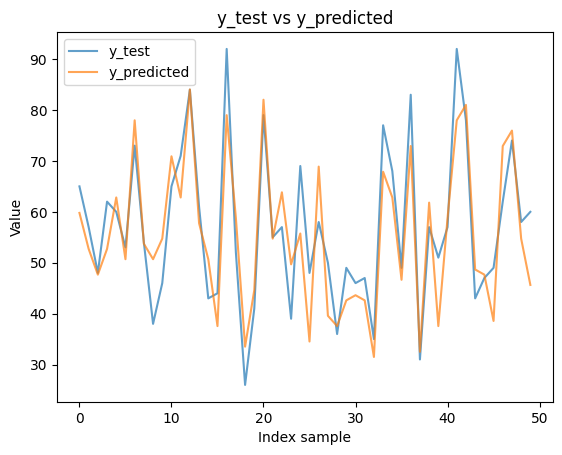

In [40]:
plot_compare(y_test_ndarray, y_predicted_best_feature_model)

Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -14.989 + 1.011*PS$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất

## Xây dựng/Thiết kế mô hình

In [41]:
#chuẩn bị 
muy_ps = np.mean(X_train["Previous Scores"])
std_ps = np.std(X_train["Previous Scores"])
max_hs = X_train["Hours Studied"].max()
max_sh = X_train["Sleep Hours"].max()
max_sqpp = X_train["Sample Question Papers Practiced"].max()

print("Mean of Previous Scores:", muy_ps)
print("Std of Previous Scores:", std_ps)
print("Max of Hours Studied:", max_hs)
print("Max of Sleep Hours:", max_sh)
print("Max of Sample Question Papers Practiced:", max_sqpp)

Mean of Previous Scores: 69.39611111111111
Std of Previous Scores: 17.368991731399728
Max of Hours Studied: 9
Max of Sleep Hours: 9
Max of Sample Question Papers Practiced: 9


### Mô hình 1

Giống như phân tích ở `Histogram và Pie Chart` ở trong báo cáo, ta thử chuẩn hóa Previous Scores và kết hợp với Hours Studied đã rescale (nhắm tránh sự lệch quá nhiều của hours studied) ở trong dataset để tạo mô hình, vì các đặc trưng này là 2 đặc trưng có hệ số tương quan cao nhất so với các đặc trưng còn lại.

In [42]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình
X_train_PS_HS = X_train[["Previous Scores", "Hours Studied"]].copy()

X_train_PS_HS["Previous Scores"] = (X_train_PS_HS["Previous Scores"] - muy_ps)/std_ps
X_train_PS_HS["Hours Studied"] = X_train_PS_HS["Hours Studied"]/X_train_PS_HS["Hours Studied"].max()
X_train_PS_HS = add_bias(df_to_numpy(X_train_PS_HS))
X_train_PS_HS

array([[ 1.        ,  0.43778528,  0.77777778],
       [ 1.        ,  1.18624554,  0.88888889],
       [ 1.        ,  0.78322847,  1.        ],
       ...,
       [ 1.        , -0.25310111,  0.77777778],
       [ 1.        , -1.23185683,  0.88888889],
       [ 1.        , -0.59854431,  0.44444444]], shape=(9000, 3))

### Mô hình 2

Ở mô hình 2, vẫn tiếp tục sử dụng Previous Scores. Vì hệ số tương quan giữa Performance Index với Hours Studied (HS) là 0.37, ta thử bình phương Hours Studied để giảm sự phụ thuộc trọng số của HS, và thử sử dụng thêm Extracurricular Activities (EA) để làm thành phần đặc trưng trong mô hình

In [43]:
X_train_PS_HS_EA = X_train[["Previous Scores", "Hours Studied", "Extracurricular Activities"]].copy()
X_train_PS_HS_EA["Hours Studied"] **= 2
X_train_PS_HS_EA = add_bias(df_to_numpy(X_train_PS_HS_EA))
X_train_PS_HS_EA

array([[ 1., 77., 49.,  0.],
       [ 1., 90., 64.,  1.],
       [ 1., 83., 81.,  1.],
       ...,
       [ 1., 65., 49.,  0.],
       [ 1., 48., 64.,  0.],
       [ 1., 59., 16.,  0.]], shape=(9000, 4))

### Mô hình 3

Sau khi test thử mô hình 1 và 2 ở trước, ta thấy mô hình có vẻ hoạt động tốt với dữ liệu đã chuẩn hóa và rescale. Mô hình 3 sẽ sử dụng Previous Scores đã chuẩn hóa cùng với (Hours Studied, Sleep Hours (SH) và Sample Question Papers Practiced (SQPP) ) đã rescale, vì theo như ma trận tương quan thì SH và SQPP cũng có một chút tương quan nhẹ.

In [44]:
X_train_PS_HS_SH_SQPP = X_train[["Previous Scores", "Hours Studied", "Sleep Hours", "Sample Question Papers Practiced"]].copy()
X_train_PS_HS_SH_SQPP["Previous Scores"] = (X_train_PS_HS_SH_SQPP["Previous Scores"] - muy_ps)/std_ps
X_train_PS_HS_SH_SQPP["Hours Studied"] /= max_hs
X_train_PS_HS_SH_SQPP["Sleep Hours"] /= max_sh
X_train_PS_HS_SH_SQPP["Sample Question Papers Practiced"] /= max_sqpp
X_train_PS_HS_SH_SQPP = add_bias(df_to_numpy(X_train_PS_HS_SH_SQPP))
X_train_PS_HS_SH_SQPP


array([[ 1.        ,  0.43778528,  0.77777778,  0.55555556,  0.22222222],
       [ 1.        ,  1.18624554,  0.88888889,  0.44444444,  0.11111111],
       [ 1.        ,  0.78322847,  1.        ,  0.66666667,  0.33333333],
       ...,
       [ 1.        , -0.25310111,  0.77777778,  0.44444444,  0.11111111],
       [ 1.        , -1.23185683,  0.88888889,  0.77777778,  0.77777778],
       [ 1.        , -0.59854431,  0.44444444,  1.        ,  0.77777778]],
      shape=(9000, 5))

## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [45]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu
n_samples = len(X_train_PS_HS)
indices = np.arange(n_samples)
np.random.shuffle(indices)  


In [46]:

model_1 = OLSLinearRegression()

mse_model_1 = k_fold_cross_validation(X_train_PS_HS, y_train_ndarray, model_1, indices)
weights_1 = model_1.get_params()
print("Weights", weights_1)
print("MSE validation of model 1:", mse_model_1)


Weights [40.96601654 17.72120828 25.62573527]
MSE validation of model 1: 5.200840882311775


In [47]:
model_2 = OLSLinearRegression()
mse_model_2 = k_fold_cross_validation(X_train_PS_HS_EA, y_train_ndarray, model_2, indices)
weights_2 = model_2.get_params()
print("Weights", weights_2)
print("MSE validation of model 2:", mse_model_2)

Weights [-24.57559953   1.02065587   0.27227126   0.58989387]
MSE validation of model 2: 7.692098281914278


In [48]:
model_3 = OLSLinearRegression()
mse_model_3 = k_fold_cross_validation(X_train_PS_HS_SH_SQPP, y_train_ndarray, model_3, indices)
weights_3 = model_3.get_params()
print("Weights", weights_3)
print("MSE validation of model 3:", mse_model_3)

Weights [37.03850935 17.7167747  25.599435    4.22960117  1.6934651 ]
MSE validation of model 3: 4.256445906651097


**Chú ý**: Đây là kết quả trong shuffle đầu tiên, các lần chạy code khác có thể ra khác kết quả

<center>

| STT |           Mô hình          | MSE  |
|:---:|:--------------------------:|:----:|
|  1  | Sử dụng 2 đặc trưng Previous Score (standardized) và Hours Studied (rescaled) |5.199|
| 2   | Sử dụng 3 đặc trưng Previous Scores, Hours Studied (Squared), Extracurricular Activities|7.695|
|  3  | Sử dụng 4 đặc trưng Previous Scores (standardized), Hours Studied (rescaled), Sleep Hours (rescaled), Sample Question Papers Practiced (rescaled)|4.256|

</center>

Vậy mô hình 3 có vẻ hoạt động tốt nhất trong 3 mô hình tự xây dựng

In [49]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện

my_best_model = OLSLinearRegression()

my_best_model.fit(X_train_PS_HS_SH_SQPP, y_train_ndarray)

my_best_model_weights = my_best_model.get_params()
my_best_model_weights


array([36.98289816, 17.68227557, 25.672943  ,  4.22867374,  1.73914247])

In [50]:
# Gọi hàm MSE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
x_test_features = X_test[["Previous Scores", "Hours Studied", "Sleep Hours", "Sample Question Papers Practiced"]].copy()
x_test_features["Previous Scores"] -= muy_ps
x_test_features["Previous Scores"] /= std_ps
x_test_features["Hours Studied"] /= max_hs
x_test_features["Sleep Hours"] /= max_sh
x_test_features["Sample Question Papers Practiced"] /= max_sqpp
x_test_ndarray_normalized = add_bias(df_to_numpy(x_test_features))

predicted_my_best_model = my_best_model.predict(x_test_ndarray_normalized)

mse_my_best_model = cal_mse(y_test_ndarray, predicted_my_best_model)
print("MSE of my best model",mse_my_best_model)


MSE of my best model 4.2094729008868965


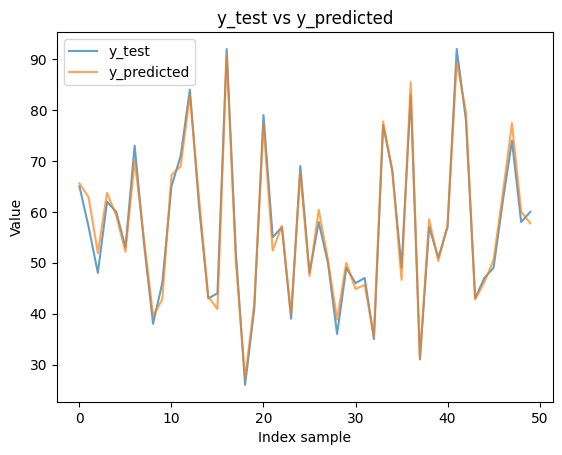

In [51]:
plot_compare(y_test_ndarray, predicted_my_best_model)

Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = 36.983 + 17.682 \cdot \frac{PS - 69.396}{17.369} + 25.673 \cdot \frac{HS}{9} + 4.229 \cdot \frac{SH}{9} + 1.739 \cdot \frac{SQPP}{9}$$